Question 1/ Newman Exercise 8.18

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def brusselator(t, y, a=1.0, b=3.0):
    x, ychem = y
    dx = 1.0 - (b + 1.0) * x + a * x * x * ychem
    dy = b * x - a * x * x * ychem
    return np.array([dx, dy], dtype=float)

def modified_midpoint(f, t0, y0, H, n):
    h = H / n
    f0 = f(t0, y0)
    z0 = y0
    z1 = y0 + h * f0
    for m in range(2, n + 1):
        tm = t0 + (m - 1) * h
        fm = f(tm, z1)
        z2 = z0 + 2.0 * h * fm
        z0, z1 = z1, z2

    fend = f(t0 + H, z1)
    y_end = 0.5 * (z1 + z0 + h * fend)
    return y_end, True

In [12]:
def bs_trial(f, t0, y0, H, delta_per_unit=1e-10, nmax=8):
    n_list = [2, 4, 6, 8]
    n_list = [n for n in n_list if n <= nmax]
    tol = delta_per_unit * abs(H)

    T = []
    for k, n in enumerate(n_list):
        y_mm, ok = modified_midpoint(f, t0, y0, H, n)
        if not ok:
            return False, y0, np.inf, n
        T.append([y_mm])

        for j in range(1, k + 1): 
            nk  = n_list[k]
            nkj = n_list[k - j]
            r = (nk / nkj) ** 2.0
            T_kj_1  = T[k][j - 1]
            T_km1_j = T[k - 1][j - 1]
            T[k].append(T_kj_1 + (T_kj_1 - T_km1_j) / (r - 1.0))

        y_best = T[k][-1]

        if k == 0:
            err = np.linalg.norm(T[k][0] - y0, ord=np.inf)
        else:
            err = np.linalg.norm(T[k][-1] - T[k - 1][-1], ord=np.inf)

        if np.isfinite(err) and err <= tol:
            return True, y_best, err, n
    return False, y0, err, n_list[-1]


In [13]:
def integrate_bs(f, t0, y0, t1, H0=20.0, delta_per_unit=1e-10, nmax=8, max_halves=40):
    t_arr = [float(t0)]
    y_arr = [np.array(y0, dtype=float)]
    boundaries = [float(t0)]

    t = float(t0)
    y = np.array(y0, dtype=float)
    H = float(H0)
    tiny = np.finfo(float).tiny * 100

    while t < t1 - 1e-14: 
        H = min(H, t1 - t)

        ok, y1, err, n_used = bs_trial(f, t, y, H, delta_per_unit=delta_per_unit, nmax=nmax)
        halves = 0
        while not ok:
            H *= 0.5
            halves += 1
            if halves > max_halves or H < tiny:
                raise RuntimeError("Cannot satisfy tolerance.")
            ok, y1, err, n_used = bs_trial(f, t, y, H, delta_per_unit=delta_per_unit, nmax=nmax)

        # accept
        t += H
        y = y1
        t_arr.append(t)
        y_arr.append(y.copy())
        boundaries.append(t)
    return np.array(t_arr), np.vstack(y_arr), np.array(boundaries)


/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_24481/1948895716.py:3: RuntimeWarning: overflow encountered in double_scalars
  dx = 1.0 - (b + 1.0) * x + a * x * x * ychem
/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_24481/1948895716.py:4: RuntimeWarning: overflow encountered in double_scalars
  dy = b * x - a * x * x * ychem
/var/folders/hf/mzwybxv54rqfdvn46vtf4l7m0000gn/T/ipykernel_24481/1948895716.py:23: RuntimeWarning: invalid value encountered in add
  y_end = 0.5 * (z1 + z0 + h * fend)


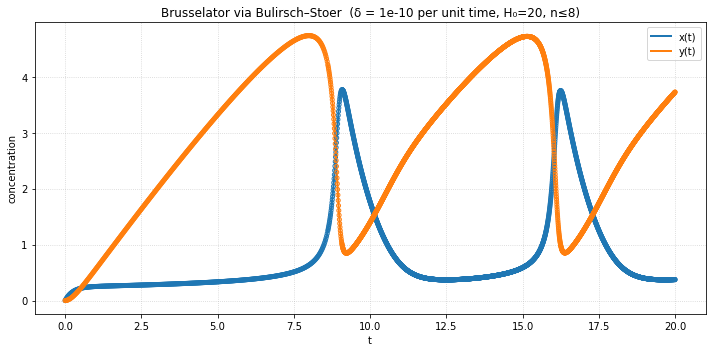

In [14]:
def main():
    a, b = 1.0, 3.0
    t0, t1 = 0.0, 20.0
    y0 = np.array([0.0, 0.0])
    H0 = 20.0               
    delta = 1e-10            
    nmax = 8                

    f = lambda t, y: brusselator(t, y, a=a, b=b)

    t_arr, y_arr, bounds = integrate_bs(f, t0, y0, t1, H0=H0, delta_per_unit=delta, nmax=nmax)
    x = y_arr[:, 0]
    ychem = y_arr[:, 1]

    plt.figure(figsize=(10, 5))
    plt.plot(t_arr, x, color="#1f77b4", lw=2.0, label="x(t)")
    plt.plot(t_arr, ychem, color="#ff7f0e", lw=2.0, label="y(t)")

    plt.scatter(bounds, np.interp(bounds, t_arr, x),
                s=16, facecolors="none", edgecolors="#1f77b4", zorder=3)
    plt.scatter(bounds, np.interp(bounds, t_arr, ychem),
                s=16, facecolors="none", edgecolors="#ff7f0e", zorder=3)

    plt.xlabel("t")
    plt.ylabel("concentration")
    plt.title("Brusselator via Bulirsch–Stoer  (δ = 1e-10 per unit time, H₀=20, n≤8)")
    plt.grid(True, ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    main()


(a) v_ap=2.236068e-04, period≈4.4429, r_min=1.000e-07, r_max=1.009e+00
(a) energy drift ΔE=3.118e-03 (relative≈1.254e-02)


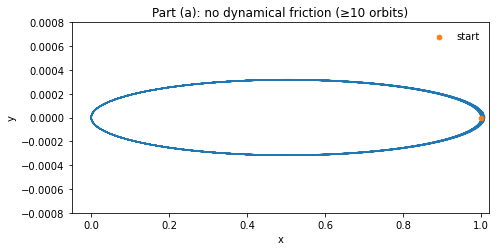

(b) finished t=10.7563, r_min=9.981e-08, reached r_s=True


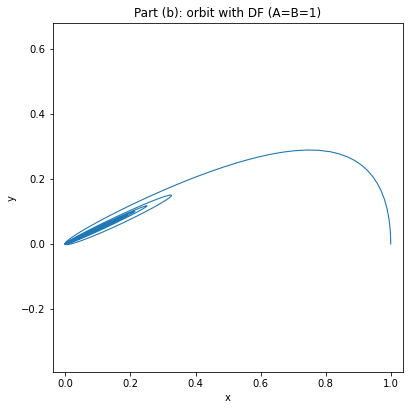

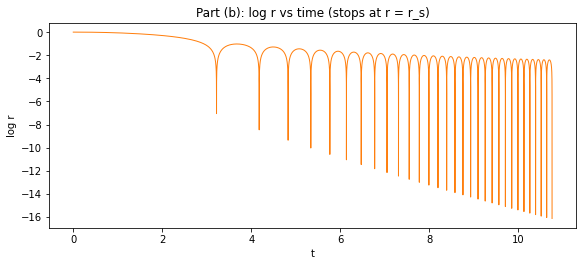

In [4]:
import math, numpy as np
import matplotlib.pyplot as plt


G = 1.0
M_BH = 1.0
MU = G * M_BH / 4.0       
R_S = 1e-7                

TOL_NO_DF = 3e-7         
TOL_DF    = 1e-6          
RTOL_MIX  = 1e-10        
SAFETY    = 0.9
GROW_MAX  = 3.0
SHRK_MIN  = 0.05
H_MIN     = 1e-24
C_KEPLER  = 0.10         


def v_circ(r: float) -> float:
    return math.sqrt(MU / r)

def vt_at_apocenter_for_rperi(r_a: float, r_p: float) -> float:
    a = 0.5 * (r_a + r_p)
    return math.sqrt((MU / a) * (r_p / r_a))

def next_float_increment(t: float) -> float:
    return float(np.nextafter(t, np.inf) - t)


def friction_ax(vx, vy, A, B):
    v = math.hypot(vx, vy)
    denom = v**3 + B
    if denom <= 0.0:
        return 0.0, 0.0
    s = -A / denom
    return s*vx, s*vy

def rhs(t, y, A=0.0, B=1.0, with_df=False):
    x, y_, vx, vy = y
    r2 = x*x + y_*y_
    r = math.sqrt(r2)
    invr3 = 1.0 / (r2*r) if r > 0.0 else 0.0
    ax = -MU * x * invr3
    ay = -MU * y_ * invr3
    if with_df:
        fx, fy = friction_ax(vx, vy, A, B)
        ax += fx; ay += fy
    return np.array([vx, vy, ax, ay], float)


def rk4_step(t, y, h, A, B, with_df):
    k1 = rhs(t,           y,            A, B, with_df)
    k2 = rhs(t + 0.5*h,   y + 0.5*h*k1, A, B, with_df)
    k3 = rhs(t + 0.5*h,   y + 0.5*h*k2, A, B, with_df)
    k4 = rhs(t + h,       y + h*k3,     A, B, with_df)
    return y + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

def try_step(t, y, h, tol_per_time, A, B, with_df):
    y_full  = rk4_step(t, y, h, A, B, with_df)
    y_half  = rk4_step(t, y, 0.5*h, A, B, with_df)
    y_half2 = rk4_step(t + 0.5*h, y_half, 0.5*h, A, B, with_df)

    err_vec = np.abs(y_half2 - y_full)
    scale   = RTOL_MIX * np.maximum(np.abs(y_half2), np.abs(y_full))
    denom   = float(tol_per_time * h + np.max(scale))
    err     = 0.0 if denom == 0.0 else float(np.max(err_vec) / denom)
    ok      = (err <= 1.0)

    if err == 0.0:
        fac = GROW_MAX
    else:
        fac = SAFETY * (err ** -0.2)     
        fac = min(GROW_MAX, max(SHRK_MIN, fac))
    return y_half2, ok, err, fac

def integrate_orbit(y0, t0, h0, tol_per_time,
                    A=0.0, B=1.0, with_df=False,
                    r_stop=0.0, t_stop=np.inf, max_steps=5_000_000):
    t = float(t0)
    y = np.array(y0, float)
    h = float(h0)
    T = [t]; Y = [y.copy()]

    for _ in range(max_steps):
        r = math.hypot(y[0], y[1])
        if (r_stop > 0.0 and r <= r_stop) or (t >= t_stop):
            break

        adv = max(H_MIN, 4.0 * next_float_increment(t))
        if h < adv: h = adv
        h_cap = C_KEPLER * (max(r, R_S)**1.5) / math.sqrt(MU)
        h = min(h, h_cap)

        y_new, ok, err, fac = try_step(t, y, h, tol_per_time, A, B, with_df)
        if ok:
            t_next = t + h
            if t_next == t:
                h = max(h, 2.0 * adv)
                continue
            t = t_next; y = y_new
            T.append(t); Y.append(y.copy())
            h *= max(1.0, fac)   # do not shrink after accept
        else:
            h *= fac
            if h < H_MIN:
                raise RuntimeError("step size underflow")

    return np.array(T), np.vstack(Y)


def run_part_a(num_orbits=10.5):
    r_a, r_p = 1.0, R_S
    v_ap = vt_at_apocenter_for_rperi(r_a, r_p)    # ensures r_peri = R_S
    a = 0.5 * (r_a + r_p)
    T = 2.0 * math.pi * a**1.5 / math.sqrt(MU)

    t, Y = integrate_orbit([r_a, 0.0, 0.0, v_ap],
                           0.0, 1e-4, TOL_NO_DF,
                           with_df=False, t_stop=num_orbits*T)

    r = np.hypot(Y[:,0], Y[:,1])
    E = 0.5 * (Y[:,2]**2 + Y[:,3]**2) - MU/r
    dE = E.max() - E.min()
    dE_rel = dE / max(1e-16, np.mean(np.abs(E)))
    print(f"(a) v_ap={v_ap:.6e}, period≈{T:.4f}, r_min={r.min():.3e}, r_max={r.max():.3e}")
    print(f"(a) energy drift ΔE={dE:.3e} (relative≈{dE_rel:.3e})")

    plt.figure(figsize=(7, 3.6))
    plt.plot(Y[:,0], Y[:,1], lw=1.4, color="C0")
    plt.scatter([Y[0,0]],[Y[0,1]], s=22, color="C1", zorder=3, label="start")
    plt.xlim(-0.05, 1.02)
    plt.ylim(-8e-4, 8e-4)
    plt.gca().set_aspect("auto")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title("Part (a): no dynamical friction (≥10 orbits)")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()


def run_part_b(A=1.0, B=1.0, speed_factor=0.8, t_cap=12.0):
    y0 = [1.0, 0.0, 0.0, speed_factor * v_circ(1.0)]
    t, Y = integrate_orbit(y0, 0.0, 1e-2, TOL_DF,
                           A=A, B=B, with_df=True,
                           r_stop=R_S, t_stop=t_cap)
    r = np.hypot(Y[:,0], Y[:,1])
    print(f"(b) finished t={t[-1]:.4f}, r_min={r.min():.3e}, reached r_s={r[-1] <= R_S + 1e-12}")

    # Path with r_s circle
    plt.figure(figsize=(5.8, 5.8))
    plt.plot(Y[:,0], Y[:,1], lw=1.1, color="C0")
    th = np.linspace(0, 2*np.pi, 400)
    plt.plot(R_S*np.cos(th), R_S*np.sin(th), ls="--", lw=0.9, color="C3")
    plt.axis("equal")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title("Part (b): orbit with DF (A=B=1)")
    plt.tight_layout()
    plt.show()

    # log r vs t
    plt.figure(figsize=(8.2, 3.8))
    plt.plot(t, np.log(r), lw=1.0, color="C1")
    plt.xlabel("t"); plt.ylabel("log r")
    plt.title("Part (b): log r vs time (stops at r = r_s)")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    run_part_a(num_orbits=10.5)
    run_part_b(A=1.0, B=1.0, speed_factor=0.8, t_cap=12.0)
